In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install imagehash

In [15]:

import os
import random
import hashlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import imagehash
from tqdm import tqdm


# =============================
# CONFIG
# =============================

BASE_PATH = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset"   # CHANGE THIS
#                        H:\MyDrive\Project work\Dataset\Epic and CSCR hospital Dataset

TRAIN_PATH = os.path.join(BASE_PATH,"Train")
TEST_PATH  = os.path.join(BASE_PATH,"Test")

In [16]:
os.path.exists(BASE_PATH)


True

In [17]:
os.path.exists(TRAIN_PATH)

True

In [18]:
os.path.exists(TEST_PATH)

True


======= DATASET AUDIT START =======


========== TRAIN CLASS COUNT ==========

glioma          : 3018
meningioma      : 2183
notumor         : 1945
pituitary       : 2504
Total: 9650

========== TEST CLASS COUNT ==========

glioma          : 755
meningioma      : 546
notumor         : 487
pituitary       : 626
Total: 2414

========== TRAIN CORRUPT CHECK ==========

Total corrupt: 0

========== TEST CORRUPT CHECK ==========

Total corrupt: 0

========== DUPLICATE CHECK ==========

Train duplicates : 0
Test duplicates  : 0
Train-Test leak  : 234
❌ DATA LEAKAGE DETECTED

========== TRAIN SIMILARITY CHECK ==========



100%|██████████| 300/300 [00:02<00:00, 113.53it/s]


Near-duplicates: 17

========== TEST SIMILARITY CHECK ==========



100%|██████████| 300/300 [00:02<00:00, 109.36it/s]


Near-duplicates: 27

========== TRAIN IMAGE SIZE ==========

Width : 150 → 1375
Height: 167 → 1446

========== TEST IMAGE SIZE ==========

Width : 150 → 1375
Height: 168 → 1446

========== TRAIN SAMPLES ==========



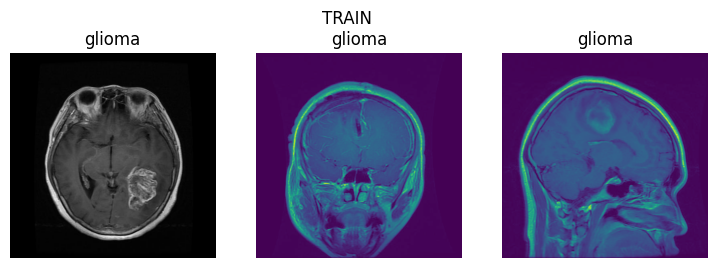

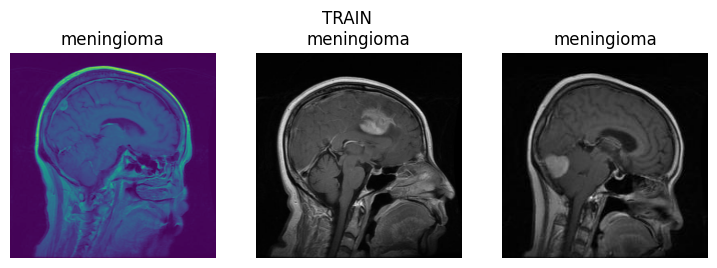

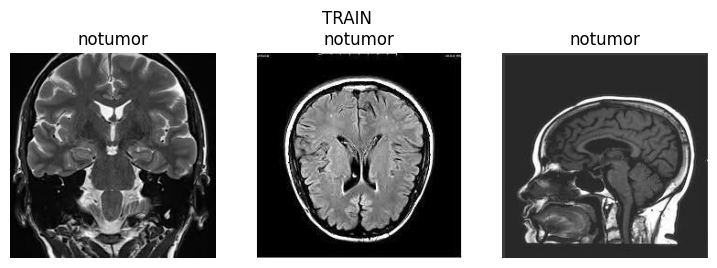

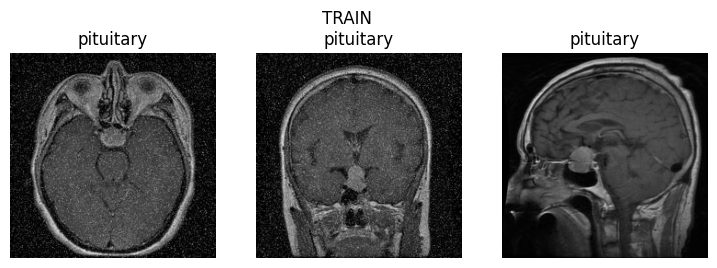


========== TEST SAMPLES ==========



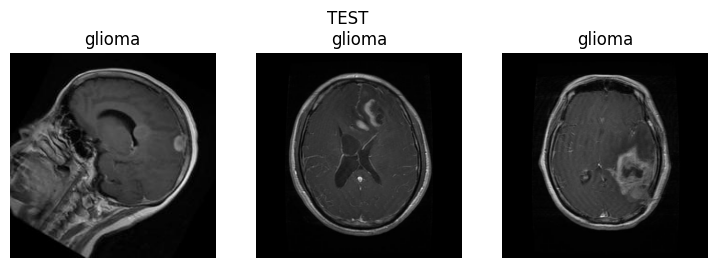

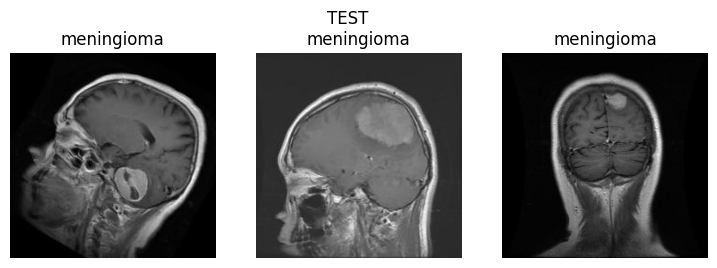

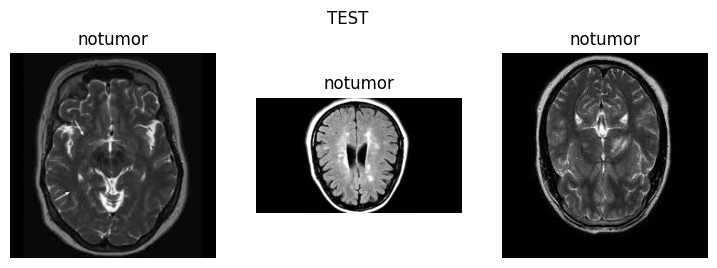

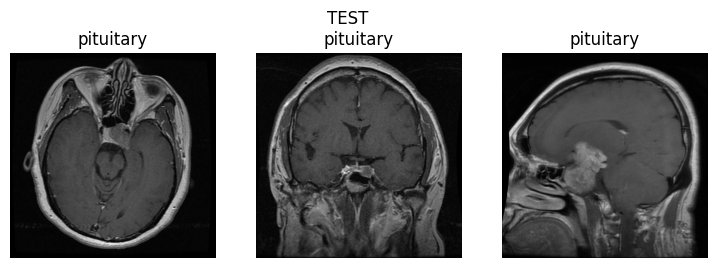


======= DATASET AUDIT DONE =======



In [19]:



# =============================
# 1. CLASS COUNT
# =============================

def count_classes(path, name):

    print(f"\n========== {name} CLASS COUNT ==========\n")

    counts = {}
    total = 0

    for cls in sorted(os.listdir(path)):

        folder = os.path.join(path,cls)

        if os.path.isdir(folder):

            n = len(os.listdir(folder))
            counts[cls] = n
            total += n

            print(f"{cls:15s} : {n}")

    print("Total:", total)

    return counts


# =============================
# 2. CORRUPT FILE CHECK
# =============================

def check_corrupt(path, name):

    print(f"\n========== {name} CORRUPT CHECK ==========\n")

    bad = 0

    for cls in os.listdir(path):

        folder = os.path.join(path,cls)

        for f in os.listdir(folder):

            p = os.path.join(folder,f)

            try:
                img = Image.open(p)
                img.verify()
            except:
                bad += 1
                print("Corrupt:", p)

    print("Total corrupt:", bad)

    return bad


# =============================
# 3. HASH COLLECTION
# =============================

def collect_hashes(path):

    hashes = {}

    for cls in os.listdir(path):

        folder = os.path.join(path,cls)

        for f in os.listdir(folder):

            p = os.path.join(folder,f)

            with open(p,"rb") as file:
                h = hashlib.md5(file.read()).hexdigest()

            hashes[h] = p

    return hashes


# =============================
# 4. DUPLICATE CHECK
# =============================

def check_duplicates(train_path, test_path):

    print("\n========== DUPLICATE CHECK ==========\n")

    train_hash = collect_hashes(train_path)
    test_hash  = collect_hashes(test_path)

    # Inside train
    train_dup = len(train_hash) - len(set(train_hash.keys()))

    # Inside test
    test_dup = len(test_hash) - len(set(test_hash.keys()))

    # Between train and test
    leakage = len(set(train_hash.keys()) & set(test_hash.keys()))

    print("Train duplicates :", train_dup)
    print("Test duplicates  :", test_dup)
    print("Train-Test leak  :", leakage)

    if leakage > 0:
        print("❌ DATA LEAKAGE DETECTED")

    return leakage


# =============================
# 5. NEAR-DUPLICATE CHECK
# =============================

def similarity_check(path, name, limit=300):

    print(f"\n========== {name} SIMILARITY CHECK ==========\n")

    files = []

    for cls in os.listdir(path):

        folder = os.path.join(path,cls)

        for f in os.listdir(folder):
            files.append(os.path.join(folder,f))

    files = random.sample(files, min(limit,len(files)))

    hashes = []

    for f in tqdm(files):
        h = imagehash.phash(Image.open(f))
        hashes.append(h)

    similar = 0

    for i in range(len(hashes)):
        for j in range(i+1,len(hashes)):
            if hashes[i] - hashes[j] <= 6:
                similar += 1

    print("Near-duplicates:", similar)

    return similar


# =============================
# 6. IMAGE SIZE CHECK
# =============================

def image_sizes(path, name):

    print(f"\n========== {name} IMAGE SIZE ==========\n")

    sizes = []

    for cls in os.listdir(path):

        folder = os.path.join(path,cls)

        for f in os.listdir(folder):

            img = Image.open(os.path.join(folder,f))
            sizes.append(img.size)

    w = [s[0] for s in sizes]
    h = [s[1] for s in sizes]

    print("Width :", min(w),"→",max(w))
    print("Height:", min(h),"→",max(h))


# =============================
# 7. VISUAL CHECK
# =============================

def show_samples(path, name, n=3):

    print(f"\n========== {name} SAMPLES ==========\n")

    for cls in sorted(os.listdir(path)):

        folder = os.path.join(path,cls)

        imgs = random.sample(os.listdir(folder), n)

        plt.figure(figsize=(9,3))

        for i,f in enumerate(imgs):

            img = Image.open(os.path.join(folder,f))

            plt.subplot(1,n,i+1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")

        plt.suptitle(name)
        plt.show()


# =============================
# MAIN
# =============================

print("\n======= DATASET AUDIT START =======\n")


train_counts = count_classes(TRAIN_PATH,"TRAIN")
test_counts  = count_classes(TEST_PATH,"TEST")

check_corrupt(TRAIN_PATH,"TRAIN")
check_corrupt(TEST_PATH,"TEST")

leak = check_duplicates(TRAIN_PATH,TEST_PATH)

similarity_check(TRAIN_PATH,"TRAIN")
similarity_check(TEST_PATH,"TEST")

image_sizes(TRAIN_PATH,"TRAIN")
image_sizes(TEST_PATH,"TEST")

show_samples(TRAIN_PATH,"TRAIN")
show_samples(TEST_PATH,"TEST")


print("\n======= DATASET AUDIT DONE =======\n")


In [20]:
import os, hashlib, shutil

SRC = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset"
DST = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset_clean"

TRAIN = os.path.join(SRC,"Train")
TEST  = os.path.join(SRC,"Test")

TRAIN_D = os.path.join(DST,"Train")
TEST_D  = os.path.join(DST,"Test")


def collect(path):
    d = {}
    for cls in os.listdir(path):
        for f in os.listdir(os.path.join(path,cls)):
            p = os.path.join(path,cls,f)
            h = hashlib.md5(open(p,'rb').read()).hexdigest()
            d[h] = p
    return d


train_h = collect(TRAIN)
test_h  = collect(TEST)

common = set(train_h) & set(test_h)

print("Leaked:", len(common))


# Copy everything first
shutil.copytree(SRC, DST)


# Remove leaked from clean test
for h in common:
    os.remove(test_h[h].replace(SRC,DST))

print("Clean dataset created.")


Leaked: 234
Clean dataset created.
